# Отображение метрик в визуальном виде и генерация данных 
Программа вызывает мое приложение, написанное на с++, то в свою очередь принимает массив на вход и возращает отсорированный массив и время выполенения  

Подколючение нашего exe + установка бибилотек

In [163]:
!pip install matplotlib
!pip install subprocess
!pip install mplcyberpunk


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement subprocess (from versions: none)

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for subprocess



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Настройка логгера
Так же настройка уровней логирования

In [164]:
import logging
import sys

SUCCESS_LEVEL_NUM = 25
logging.addLevelName(SUCCESS_LEVEL_NUM, "SUCCESS")


class ColorFormatter(logging.Formatter):
    COLORS = {
        "SUCCESS": "\033[92m",
        "INFO": "\033[94m",
        "WARNING": "\033[93m",
        "ERROR": "\033[91m",
        "CRITICAL": "\033[91m",
    }
    RESET = "\033[0m"

    def format(self, record):
        level_name = record.levelname
        msg = super().format(record)
        color = self.COLORS.get(level_name)
        if color:
            msg = f"{color}{msg}{self.RESET}"
        return msg


def get_logger(name: str = "qs_logger") -> logging.Logger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.DEBUG)

    if not logger.handlers:
        handler = logging.StreamHandler(sys.stdout)
        fmt = "[%(levelname)s] %(message)s"
        handler.setFormatter(ColorFormatter(fmt))
        logger.addHandler(handler)

    def success(self, msg, *args, **kwargs):
        if self.isEnabledFor(SUCCESS_LEVEL_NUM):
            self._log(SUCCESS_LEVEL_NUM, msg, args, **kwargs)

    logging.Logger.success = success

    return logger


logger = get_logger()

### Проверка валидности
Что пусть до exe файла существует и выводит его

In [165]:
from pathlib import Path
import subprocess
import random
import matplotlib.pyplot as plt

ROOT = Path().resolve()

EXE_PATH = ROOT / "cmake-build-debug/Debug/QuickSort.exe"
logger.info(f"EXE_PATH: {EXE_PATH}")
if not EXE_PATH.exists():
    logger.error(f"Exe path is not found: {EXE_PATH}")
    raise FileNotFoundError(f"Exe path is not found {EXE_PATH}")

logger.success(f"Successfully found exe path: {EXE_PATH}")


[INFO] EXE_PATH: C:\Users\SyperOlao\CLionProjects\QuickSort\cmake-build-debug\Debug\QuickSort.exe
[SUCCESS] Successfully found exe path: C:\Users\SyperOlao\CLionProjects\QuickSort\cmake-build-debug\Debug\QuickSort.exe


### Настройка внешнего вида графиков

In [166]:
import seaborn as sns

sns.set_theme(style="darkgrid")
# plt.style.use("dark_background")

import mplcyberpunk
plt.style.use("cyberpunk")

# Скрипт запуска с++ программы
 Передача в функцию:
 - exe_path - путь до исполняемого файла сорировки
 - dtype - строка с типом данных массива **dtype: 'int' | 'double' | 'char'**
 - data - несортированный массив данных

In [167]:
def run_cpp_sort(exe_path: Path, dtype: str, data):
    n = len(data)
    if n == 0:
        logger.warning("Передан пустой список данных, возвращаю (0.0, []).")
        return 0.0, []

    stdin_str = " ".join(str(x) for x in data)

    proc = subprocess.run(
        [str(exe_path), dtype, str(n)],
        input=stdin_str,
        text=True,
        capture_output=True,
    )

    if proc.returncode != 0:
        logger.error(f"C++ code failed, return code: {proc.returncode}")
        logger.warning("STDOUT:\n" + proc.stdout)
        logger.warning("STDERR:\n" + proc.stderr)
        raise RuntimeError("QuickSort.exe вернул ошибку")

    time_ms = None
    sorted_raw = None

    for line in proc.stdout.splitlines():
        parts = line.strip().split()
        if not parts:
            continue
        if parts[0] == "TIME_MS":
            try:
                time_ms = float(parts[1])
            except ValueError:
                logger.error(f"Не удалось распарсить TIME_MS из строки: {line!r}")
        elif parts[0] == "DATA":
            sorted_raw = parts[1:]

    if time_ms is None or sorted_raw is None:
        logger.error("Не удалось найти TIME_MS или DATA в выводе C++")
        logger.warning("Полный STDOUT C++:\n" + proc.stdout)
        raise RuntimeError("Uncompressible  output from C++")

    if dtype == "int":
        result = [int(x) for x in sorted_raw]
    elif dtype == "double":
        result = [float(x) for x in sorted_raw]
    elif dtype == "char":
        result = [x for x in sorted_raw]
    elif dtype == "point":
        result = []
        for token in sorted_raw:
            xs, ys = token.split(",")
            result.append((float(xs), float(ys)))
    else:
        logger.error(f"Undefined dtype: {dtype}")
        raise ValueError(f"Undefined dtype: {dtype}")

    return time_ms, result


# Тестовые данные
Базовая проверка работоспособности скрипта на массиве из 10 чисел со значениями от -50 до 50,
Так же проверка метода сортировки питона и с++ так же вывод времени выполнения сортировки из программы

In [168]:
test_data = [random.randint(-50, 50) for _ in range(10)]

t_ms, sorted_data = run_cpp_sort(EXE_PATH, "int", test_data)

logger.info(f"Вход:    {test_data}")
logger.success(f"Выход:   {sorted_data}")
logger.success(f"Python:  {sorted(test_data)}")
logger.success(f"Ок?:     {sorted_data == sorted(test_data)}")
logger.success(f"Время:   {t_ms} мс")


[INFO] Вход:    [-45, 13, 25, 23, 38, 34, -11, 22, -12, 38]
[SUCCESS] Выход:   [-45, -12, -11, 13, 22, 23, 25, 34, 38, 38]
[SUCCESS] Python:  [-45, -12, -11, 13, 22, 23, 25, 34, 38, 38]
[SUCCESS] Ок?:     True
[SUCCESS] Время:   0.0009 мс


### Функция генерации данных
генерируеют случайные, отсортированные, реверсивные, частично сортированные и мало уникальные данные

In [169]:
import string

def make_data(dtype: str, n: int, pattern: str, seed: int | None = None):
    """
    dtype: 'int' | 'double' | 'char' | 'point'
    pattern: 'random' | 'sorted' | 'reversed' | 'partial_sorted' | 'few_unique'
    """
    rnd = random.Random(seed)
    alphabet = string.ascii_letters

    if dtype == "int":
        base = [rnd.randint(-10_000, 10_000) for _ in range(n)]
    elif dtype == "double":
        base = [rnd.uniform(-1e3, 1e3) for _ in range(n)]
    elif dtype == "char":
        base = [rnd.choice(alphabet) for _ in range(n)]
    elif dtype == "point":
        base = [(rnd.uniform(-1e3, 1e3), rnd.uniform(-1e3, 1e3)) for _ in range(n)]
    else:
        logger.error(f"Unknown dtype in make_data: {dtype}")
        raise ValueError(f"Unknown dtype: {dtype}")

    def point_key(p):
        return (p[0], p[1])

    if pattern == "random":
        return base
    elif pattern == "sorted":
        if dtype == "point":
            return sorted(base, key=point_key)
        else:
            return sorted(base)
    elif pattern == "reversed":
        if dtype == "point":
            return sorted(base, key=point_key, reverse=True)
        else:
            return sorted(base, reverse=True)
    elif pattern == "partial_sorted":
        k = max(1, int(n * 0.8))
        if dtype == "point":
            head = sorted(base[:k], key=point_key)
        else:
            head = sorted(base[:k])
        tail = base[k:]
        return head + tail
    elif pattern == "few_unique":
        if dtype == "char":
            uniq_vals = [rnd.choice(alphabet) for _ in range(max(2, min(10, n // 5)))]
            return [rnd.choice(uniq_vals) for _ in range(n)]
        elif dtype in ("int", "double"):
            uniq_count = max(2, min(10, n // 5))
            if dtype == "int":
                uniq_vals = [rnd.randint(-100, 100) for _ in range(uniq_count)]
            else:
                uniq_vals = [rnd.uniform(-100, 100) for _ in range(uniq_count)]
            return [rnd.choice(uniq_vals) for _ in range(n)]
        elif dtype == "point":
            uniq_count = max(2, min(10, n // 5))
            uniq_vals = [
                (rnd.uniform(-100, 100), rnd.uniform(-100, 100))
                for _ in range(uniq_count)
            ]
            return [rnd.choice(uniq_vals) for _ in range(n)]
    else:
        logger.error(f"Unknown pattern: {pattern}")
        raise ValueError(f"Unknown pattern: {pattern}")


### Проверка валидности данных

In [170]:
def check_sorted(dtype: str, data, sorted_data, pattern: str, n: int):
    """
    Проверка корректности результата сортировки.
    Для int/char — строгая, для double — только порядок.
    """
    if len(sorted_data) != len(data):
        logger.error(
            f"[CHECK] Размеры не совпадают: cpp={len(sorted_data)}, py={len(data)}, "
            f"dtype={dtype}, pattern={pattern}, n={n}"
        )
        raise RuntimeError("C++ сортировка дала неправильный результат (len mismatch)")

    if dtype in ("int", "char"):
        py_sorted = sorted(data)
        if sorted_data != py_sorted:
            logger.error(
                f"[CHECK] Неверная сортировка: dtype={dtype}, pattern={pattern}, n={n}"
            )
            logger.warning(f"py_sorted[:10]  = {py_sorted[:10]}")
            logger.warning(f"cpp_sorted[:10] = {sorted_data[:10]}")
            raise RuntimeError("C++ сортировка дала неправильный результат")
        return


    if dtype == "double":
        m = len(sorted_data)
        eps = 1e-9

        for i in range(m - 1):
            if sorted_data[i] - sorted_data[i + 1] > eps:
                logger.error(
                    f"[CHECK] Порядок нарушен в double: idx={i}, "
                    f"{sorted_data[i]} > {sorted_data[i+1]} "
                    f"(diff={sorted_data[i]-sorted_data[i+1]})"
                )
                raise RuntimeError("C++ сортировка дала неправильный порядок для double")


        lo, hi = min(data), max(data)
        for x in sorted_data:
            if x < lo - 1 or x > hi + 1:
                logger.error(
                    f"[CHECK] Значение double вышло за пределы исходного диапазона: {x}, "
                    f"orig_range=({lo}, {hi})"
                )
                raise RuntimeError("C++ сортировка дала странные значения для double")
        return

    if dtype == "point":
        m = len(sorted_data)
        eps = 1e-6

        def less(a, b):
            if a[0] < b[0] - eps:
                return True
            if a[0] > b[0] + eps:
                return False
            return a[1] < b[1] - eps

        for i in range(m - 1):
            if less(sorted_data[i + 1], sorted_data[i]):
                logger.error(
                    f"[CHECK] Порядок нарушен в point: idx={i}, "
                    f"a={sorted_data[i]}, b={sorted_data[i+1]}"
                )
                raise RuntimeError("C++ сортировка дала неправильный порядок для point")
        return

    logger.warning(f"[CHECK] Тип {dtype} не проверяется явно.")


In [171]:
def benchmark_dtype(dtype: str,
                    sizes: list[int],
                    patterns: list[str],
                    repeats: int = 3):
    """
    Возвращает dict: pattern -> список времен по размерам sizes
    """
    results: dict[str, list[float]] = {p: [] for p in patterns}

    for pattern in patterns:
        logger.info(f"=== dtype={dtype}, pattern={pattern} ===")
        for n in sizes:
            times = []
            for r in range(repeats):
                seed = 1234 + r
                data = make_data(dtype, n, pattern, seed=seed)
                t_ms, sorted_data = run_cpp_sort(EXE_PATH, dtype, data)

                if n <= 5000:
                    check_sorted(dtype, data, sorted_data, pattern, n)

                times.append(t_ms)

            avg_time = sum(times) / len(times)
            results[pattern].append(avg_time)
            logger.success(
                f"dtype={dtype}, pattern={pattern}, n={n}: {avg_time:.4f} ms (avg of {repeats})"
            )

    return results


### Отрисовка линий

In [172]:
from typing import Mapping

def plot_lines(
    x_values: list[int],
    series: Mapping[str, list[float]],
    title: str,
    xlabel: str = "Количество элементов",
    ylabel: str = "Время, мс",
):
    """
    series: dict {label: [y1, y2, ...]} по тем же x_values
    """
    fig, ax = plt.subplots(figsize=(15, 6))

    colors = [
        "#4C78A8",  # синий
        "#F58518",  # оранжевый
        "#54A24B",  # зелёный
        "#E45756",  # красный
        "#B279A2",  # фиолетовый
        "#FF9DA6",  # розоватый
    ]
    markers = ["o", "s", "D", "^", "v", "P"]

    for (label, y_values), color, marker in zip(series.items(), colors, markers):
        ax.plot(
            x_values,
            y_values,
            label=label,
            marker=marker,
            linewidth=2,
            markersize=7,
            color=color,
        )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    ax.legend(title="Тип данных", frameon=True)
    fig.tight_layout()
    return fig, ax


### Настройка прямых
Генерация размеров данных, паттернов и названий прямых

In [173]:
sizes = [50, 500, 1000]
patterns = ["random", "sorted", "reversed", "partial_sorted", "few_unique"]

pattern_labels = {
    "random": "случайные",
    "sorted": "отсортированные",
    "reversed": "обратный порядок",
    "partial_sorted": "частично отсортированные",
    "few_unique": "мало уникальных",
}


# График распределения для **INT**

[INFO] === dtype=int, pattern=random ===
[SUCCESS] dtype=int, pattern=random, n=50: 0.0025 ms (avg of 3)
[SUCCESS] dtype=int, pattern=random, n=500: 0.0216 ms (avg of 3)
[SUCCESS] dtype=int, pattern=random, n=1000: 0.0468 ms (avg of 3)
[INFO] === dtype=int, pattern=sorted ===
[SUCCESS] dtype=int, pattern=sorted, n=50: 0.0010 ms (avg of 3)
[SUCCESS] dtype=int, pattern=sorted, n=500: 0.0063 ms (avg of 3)
[SUCCESS] dtype=int, pattern=sorted, n=1000: 0.0132 ms (avg of 3)
[INFO] === dtype=int, pattern=reversed ===
[SUCCESS] dtype=int, pattern=reversed, n=50: 0.0011 ms (avg of 3)
[SUCCESS] dtype=int, pattern=reversed, n=500: 0.0065 ms (avg of 3)
[SUCCESS] dtype=int, pattern=reversed, n=1000: 0.0137 ms (avg of 3)
[INFO] === dtype=int, pattern=partial_sorted ===
[SUCCESS] dtype=int, pattern=partial_sorted, n=50: 0.0017 ms (avg of 3)
[SUCCESS] dtype=int, pattern=partial_sorted, n=500: 0.0164 ms (avg of 3)
[SUCCESS] dtype=int, pattern=partial_sorted, n=1000: 0.0447 ms (avg of 3)
[INFO] === dtype

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'QuickSort: int'}, xlabel='Количество элементов', ylabel='Время, мс'>)

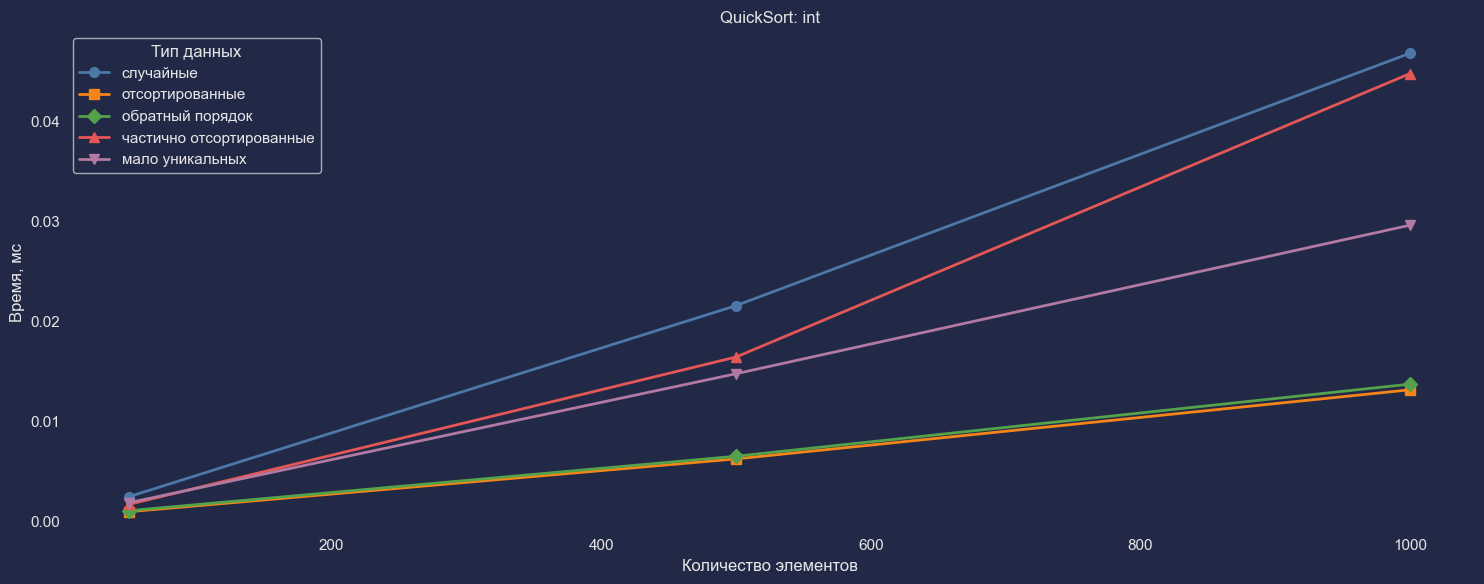

In [174]:
int_results_raw = benchmark_dtype("int", sizes, patterns, repeats=3)
int_results = {pattern_labels[k]: v for k, v in int_results_raw.items()}
plot_lines(sizes, int_results, "QuickSort: int")

# График распределения для **DOUBLE**

[INFO] === dtype=double, pattern=random ===
[SUCCESS] dtype=double, pattern=random, n=50: 0.0028 ms (avg of 3)
[SUCCESS] dtype=double, pattern=random, n=500: 0.0244 ms (avg of 3)
[SUCCESS] dtype=double, pattern=random, n=1000: 0.0573 ms (avg of 3)
[INFO] === dtype=double, pattern=sorted ===
[SUCCESS] dtype=double, pattern=sorted, n=50: 0.0010 ms (avg of 3)
[SUCCESS] dtype=double, pattern=sorted, n=500: 0.0065 ms (avg of 3)
[SUCCESS] dtype=double, pattern=sorted, n=1000: 0.0138 ms (avg of 3)
[INFO] === dtype=double, pattern=reversed ===
[SUCCESS] dtype=double, pattern=reversed, n=50: 0.0011 ms (avg of 3)
[SUCCESS] dtype=double, pattern=reversed, n=500: 0.0070 ms (avg of 3)
[SUCCESS] dtype=double, pattern=reversed, n=1000: 0.0145 ms (avg of 3)
[INFO] === dtype=double, pattern=partial_sorted ===
[SUCCESS] dtype=double, pattern=partial_sorted, n=50: 0.0021 ms (avg of 3)
[SUCCESS] dtype=double, pattern=partial_sorted, n=500: 0.0169 ms (avg of 3)
[SUCCESS] dtype=double, pattern=partial_sorte

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'QuickSort: double'}, xlabel='Количество элементов', ylabel='Время, мс'>)

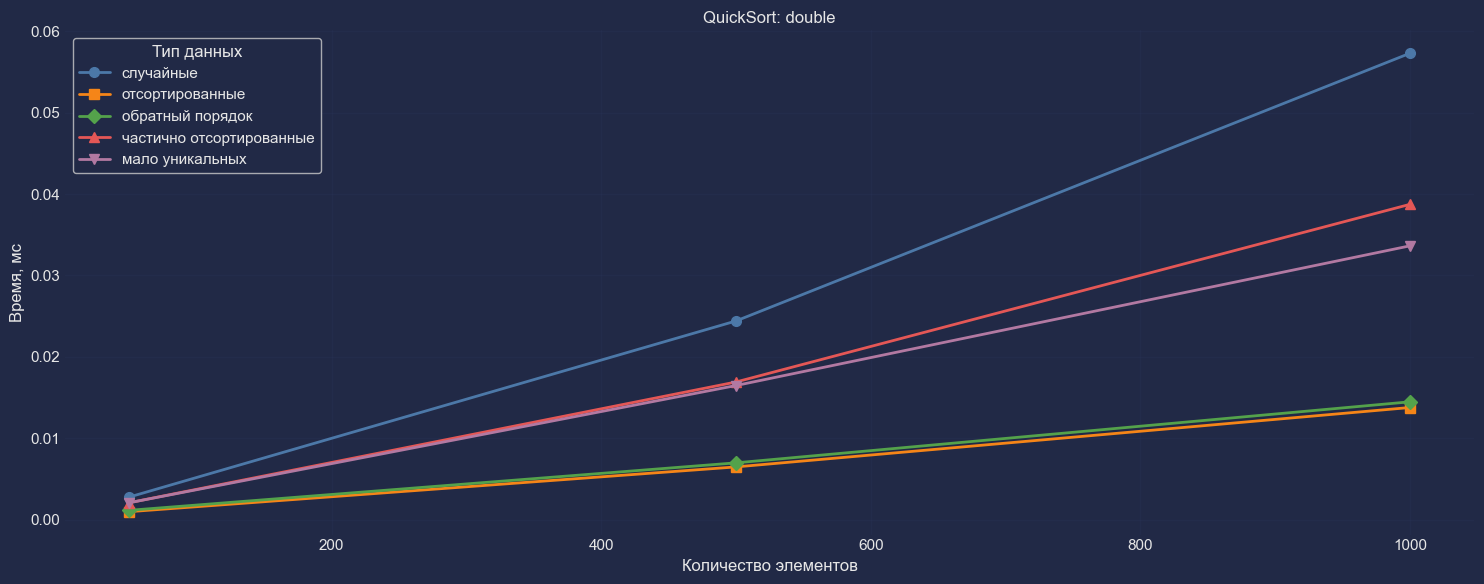

In [175]:
double_results_raw = benchmark_dtype("double", sizes, patterns, repeats=3)
double_results = {pattern_labels[k]: v for k, v in double_results_raw.items()}
plot_lines(sizes, double_results, "QuickSort: double")


# График распределения для **CHAR**

[INFO] === dtype=char, pattern=random ===
[SUCCESS] dtype=char, pattern=random, n=50: 0.0024 ms (avg of 3)
[SUCCESS] dtype=char, pattern=random, n=500: 0.0207 ms (avg of 3)
[SUCCESS] dtype=char, pattern=random, n=1000: 0.0410 ms (avg of 3)
[INFO] === dtype=char, pattern=sorted ===
[SUCCESS] dtype=char, pattern=sorted, n=50: 0.0011 ms (avg of 3)
[SUCCESS] dtype=char, pattern=sorted, n=500: 0.0079 ms (avg of 3)
[SUCCESS] dtype=char, pattern=sorted, n=1000: 0.0171 ms (avg of 3)
[INFO] === dtype=char, pattern=reversed ===
[SUCCESS] dtype=char, pattern=reversed, n=50: 0.0012 ms (avg of 3)
[SUCCESS] dtype=char, pattern=reversed, n=500: 0.0084 ms (avg of 3)
[SUCCESS] dtype=char, pattern=reversed, n=1000: 0.0184 ms (avg of 3)
[INFO] === dtype=char, pattern=partial_sorted ===
[SUCCESS] dtype=char, pattern=partial_sorted, n=50: 0.0020 ms (avg of 3)
[SUCCESS] dtype=char, pattern=partial_sorted, n=500: 0.0150 ms (avg of 3)
[SUCCESS] dtype=char, pattern=partial_sorted, n=1000: 0.0505 ms (avg of 3)


(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'QuickSort: char'}, xlabel='Количество элементов', ylabel='Время, мс'>)

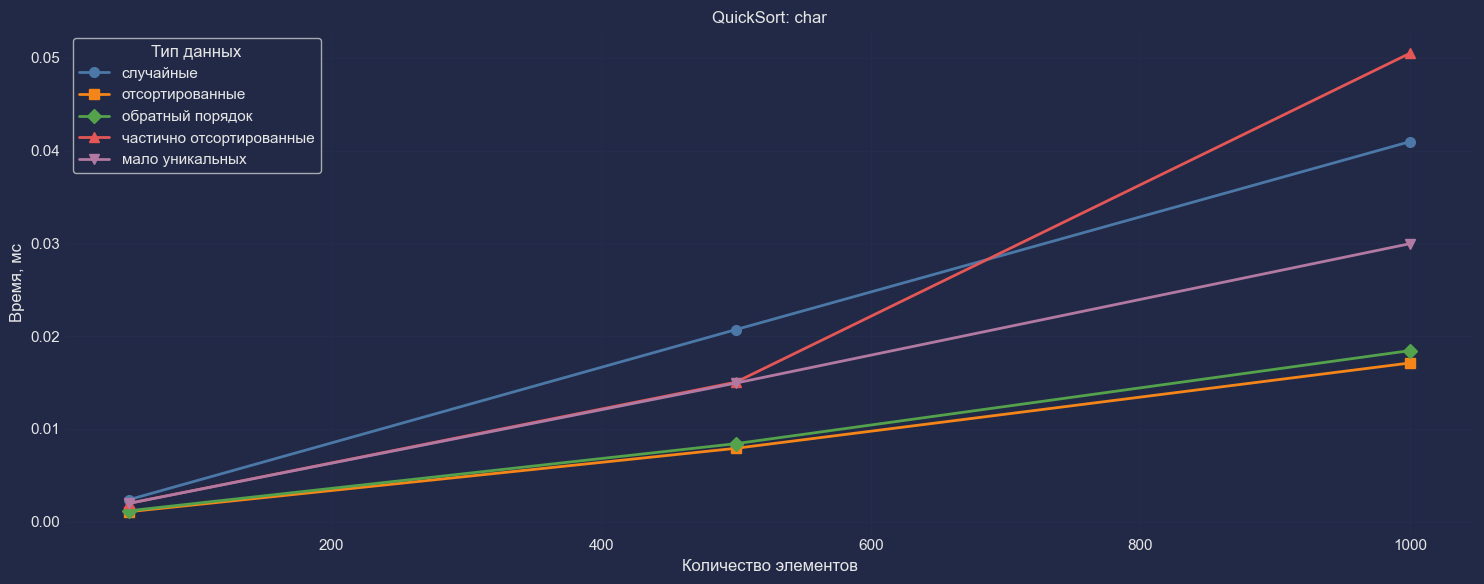

In [176]:
char_results_raw = benchmark_dtype("char", sizes, patterns, repeats=3)
char_results = {pattern_labels[k]: v for k, v in char_results_raw.items()}
plot_lines(sizes, char_results, "QuickSort: char")

# График распределения для **POINT** (нетривиальный тип)

[INFO] === dtype=point, pattern=random ===
[SUCCESS] dtype=point, pattern=random, n=50: 0.0022 ms (avg of 3)
[SUCCESS] dtype=point, pattern=random, n=500: 0.0236 ms (avg of 3)
[SUCCESS] dtype=point, pattern=random, n=1000: 0.0617 ms (avg of 3)
[INFO] === dtype=point, pattern=sorted ===
[SUCCESS] dtype=point, pattern=sorted, n=50: 0.0017 ms (avg of 3)
[SUCCESS] dtype=point, pattern=sorted, n=500: 0.0235 ms (avg of 3)
[SUCCESS] dtype=point, pattern=sorted, n=1000: 0.0570 ms (avg of 3)
[INFO] === dtype=point, pattern=reversed ===
[SUCCESS] dtype=point, pattern=reversed, n=50: 0.0020 ms (avg of 3)
[SUCCESS] dtype=point, pattern=reversed, n=500: 0.0235 ms (avg of 3)
[SUCCESS] dtype=point, pattern=reversed, n=1000: 0.0542 ms (avg of 3)
[INFO] === dtype=point, pattern=partial_sorted ===
[SUCCESS] dtype=point, pattern=partial_sorted, n=50: 0.0018 ms (avg of 3)
[SUCCESS] dtype=point, pattern=partial_sorted, n=500: 0.0236 ms (avg of 3)
[SUCCESS] dtype=point, pattern=partial_sorted, n=1000: 0.054

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'QuickSort: Point (x, y)'}, xlabel='Количество элементов', ylabel='Время, мс'>)

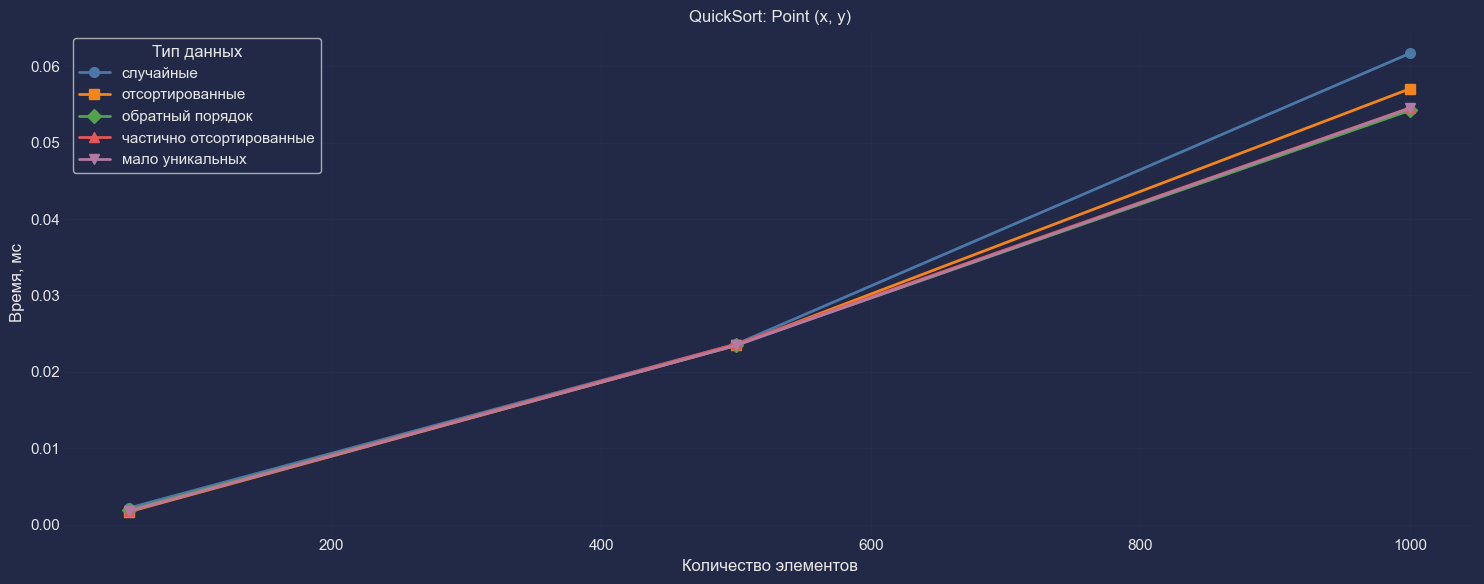

In [177]:
point_results_raw = benchmark_dtype("point", sizes, patterns, repeats=3)
point_results = {pattern_labels[k]: v for k, v in point_results_raw.items()}
plot_lines(sizes, point_results, "QuickSort: Point (x, y)")